# Imports, data input, and plotting functions

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import ast
from scipy import interpolate
import scipy.stats
import os
sns.set_style(style="ticks")
sns.set_palette("colorblind")

In [3]:
T_dur = 4
exp_measures = pd.read_csv("data/measures.csv")

print("Number of trials with outlier RTs: %i" % len(exp_measures[(exp_measures.RT > T_dur)]))
exp_measures = exp_measures[(exp_measures.RT < T_dur) | np.isnan(exp_measures.RT)]
print("Number of trials after excluding outlier RTs: %i" % len(exp_measures))

condition_map = utils.get_nudge_condition_map()
conditions = condition_map.values()
exp_measures["a_values"] = exp_measures.a_values.apply(ast.literal_eval).apply(tuple)
exp_measures["condition"] = pd.Categorical(exp_measures["a_values"].map(condition_map), categories=condition_map.values(), ordered=True)

print("Number of trials with missing RTs: %i" % len(exp_measures[np.isnan(exp_measures.RT)]))
exp_measures_no_missing_RT = exp_measures[~np.isnan(exp_measures.RT)]
print("Number of trials after excluding outlier and with outlier RTs: %i" % len(exp_measures_no_missing_RT))

Number of trials with outlier RTs: 24
Number of trials after excluding outlier RTs: 3776
Number of trials with missing RTs: 789
Number of trials after excluding outlier and with outlier RTs: 2987


In [4]:
def draw_bracket(ax, label, x1, x2, y, h=0.03, x_offset=0.04, lw=1.0):    
    ax.plot([x1+x_offset, x1+x_offset, x2-x_offset, x2-x_offset], [y, y+h, y+h, y], lw=lw, color="grey")
    ax.text((x1+x2)*.5, y+h, label, ha='center', va='bottom', color="grey")

def plot_var_by_condition(exp_measures, model_measures, var, include_model=True, include_legend=False, legend_position=(0.58, 0.83), subfigure_label="", subfigure_title="", annotate=False, fig=None, ax=None):
    tta_conditions = [4.5, 5.5]
    d_0 = 80
    markers=["o", "s"]
    marker_size = 7
    colors = ["C0", "C1"]
    
    # For s.e.m.
    # z = 1
    # For 95% CI
    z = 1.96
    
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(3,3), sharex=True, sharey=True)
        
    for tta, color, marker in zip(tta_conditions, colors, markers):
        exp_measures_by_condition = exp_measures[(exp_measures.tta_0 == tta)]
        if (var == "is_go_decision"):
            psf_ci = utils.get_psf_ci(exp_measures_by_condition, var=var, z=z)
            ax.plot(psf_ci.condition, psf_ci.p, ls="", marker=marker, ms=marker_size, color=color, zorder=10)
            ax.vlines(x=psf_ci.condition, ymin=psf_ci.ci_l, ymax=psf_ci.ci_r, color=color, zorder=10)
        else:
            exp_measures_by_condition = (exp_measures_by_condition[(exp_measures_by_condition.is_go_decision)]
                                         if (var == "RT_go") | (var == "is_negative_rating_go") 
                                         else exp_measures_by_condition[~(exp_measures_by_condition.is_go_decision)])

            if (var == "RT_go") | (var == "RT_stay"):
                measures_mean_sem = utils.get_mean_sem(exp_measures_by_condition, var="RT",
                                                       groupby_var="condition", n_cutoff=10).reindex(conditions)
                ax.errorbar(measures_mean_sem.index, measures_mean_sem["mean"], yerr=z*measures_mean_sem["sem"], ls="", marker=marker, ms=marker_size, color=color)
            elif (var == "is_negative_rating_go") | (var == "is_negative_rating_stay"):
                psf_ci = utils.get_psf_ci(exp_measures_by_condition, var="is_negative_rating", z=z)
                ax.plot(psf_ci.condition, psf_ci.p, ls="", marker=marker, ms=marker_size, color=color, zorder=10)
                ax.vlines(x=psf_ci.condition, ymin=psf_ci.ci_l, ymax=psf_ci.ci_r, color=color, zorder=10)
        
        if include_model:
            model_measures_by_condition = model_measures[(model_measures.tta_0==tta) & (model_measures.d_0==d_0)].sort_values("condition")
            ax.plot(model_measures_by_condition.condition, model_measures_by_condition[var], color=color, label=tta)

    if var=="is_go_decision":
        ylabel = "p(go)"
        ax.set_ylim((0, 1))
    elif "is_negative_rating" in var:
        ylabel = "p(negative rating)"
        ax.set_ylim((-0.05, 0.9))
    elif var=="RT_go":
        ylabel = "go RT"
        ax.set_ylim((0.2, 2.2))
    elif var=="RT_stay":
        ylabel = "stay RT"
        ax.set_ylim((0.2, 2.2))

    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_title(subfigure_title, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    
    ax.set_title(subfigure_label, loc="left", fontsize=12)

    sns.despine(ax=ax, offset=5, trim=True)

    fig.set_tight_layout(True)

    if include_legend:
        legend_elements = ([Line2D([0], [0], color=color, marker=marker, ms=marker_size, lw=0,
                                   label="Data, TTA=%.1fs" % (tta_condition))
                            for tta_condition, color, marker in zip(tta_conditions, colors, markers)]
                           + ([Line2D([0], [0], color="grey", label="Model")] if include_model else []))

        fig.legend(handles=legend_elements, loc="lower left", bbox_to_anchor=legend_position, fontsize=12, frameon=False)
        
    if annotate:
        # 0: Long acceleration
        # 1: Acceleration nudge
        # 2: Constant speed
        # 3: Deceleration nudge
        # 4: Long deceleration
        if var=="is_go_decision":
            draw_bracket(ax=ax, label="***", x1=0, x2=2, y=0.0)            
            draw_bracket(ax=ax, label="ns", x1=1, x2=2, y=0.17)
            draw_bracket(ax=ax, label="***", x1=2, x2=4, y=0.0)
            draw_bracket(ax=ax, label="***", x1=2, x2=3, y=0.17)
        if var=="RT_go":
            draw_bracket(ax=ax, label="ns", x1=0, x2=2, y=1.5)            
            draw_bracket(ax=ax, label="ns", x1=1, x2=2, y=1.0)
            draw_bracket(ax=ax, label="***", x1=2, x2=4, y=1.5)
            draw_bracket(ax=ax, label="ns", x1=2, x2=3, y=1.0)
        if var=="RT_stay":
            draw_bracket(ax=ax, label="ns", x1=0, x2=2, y=0.25)            
            draw_bracket(ax=ax, label="ns", x1=1, x2=2, y=0.75)
            draw_bracket(ax=ax, label="ns", x1=2, x2=4, y=0.25)
            draw_bracket(ax=ax, label="ns", x1=2, x2=3, y=0.75)
        if var=="is_negative_rating_stay":          
            draw_bracket(ax=ax, label="***", x1=2, x2=4, y=0.25)
            draw_bracket(ax=ax, label="*", x1=2, x2=3, y=0.5)
    return fig, ax
    # plt.savefig("figures/%s_%s_model_%r.png" % (var, model_label, include_model), bbox_inches="tight")

# Figure 3: Experimental results

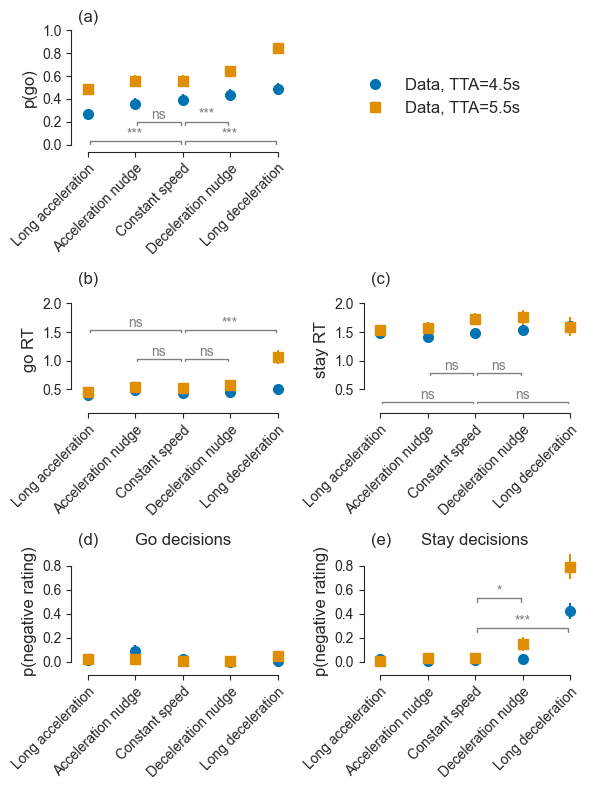

In [106]:
fig = plt.figure(figsize=(6, 8))

ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=1)
plot_var_by_condition(exp_measures, None, var="is_go_decision", include_model=False, include_legend=True, subfigure_label="(a)", annotate=True, fig=fig, ax=ax1)
ax2 = plt.subplot2grid((3, 2), (1, 0))
plot_var_by_condition(exp_measures_no_missing_RT, None, var="RT_go", include_model=False, include_legend=False, subfigure_label="(b)", annotate=True, fig=fig, ax=ax2)
ax3 = plt.subplot2grid((3, 2), (1, 1))
plot_var_by_condition(exp_measures_no_missing_RT, None, var="RT_stay", include_model=False, include_legend=False, subfigure_label="(c)", annotate=True, fig=fig, ax=ax3)
ax4 = plt.subplot2grid((3, 2), (2, 0))
plot_var_by_condition(exp_measures, None, var="is_negative_rating_go", include_model=False, include_legend=False, subfigure_label="(d)", annotate=True, subfigure_title="Go decisions", fig=fig, ax=ax4)
ax5 = plt.subplot2grid((3, 2), (2, 1))
plot_var_by_condition(exp_measures, None, var="is_negative_rating_stay", include_model=False, include_legend=False, subfigure_label="(e)", annotate=True, subfigure_title="Stay decisions", fig=fig, ax=ax5)

for ax in fig.axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

fig.set_tight_layout(True)
plt.savefig("figures/experiment_results.pdf", bbox_inches="tight")

# Figure 4: Modeling results

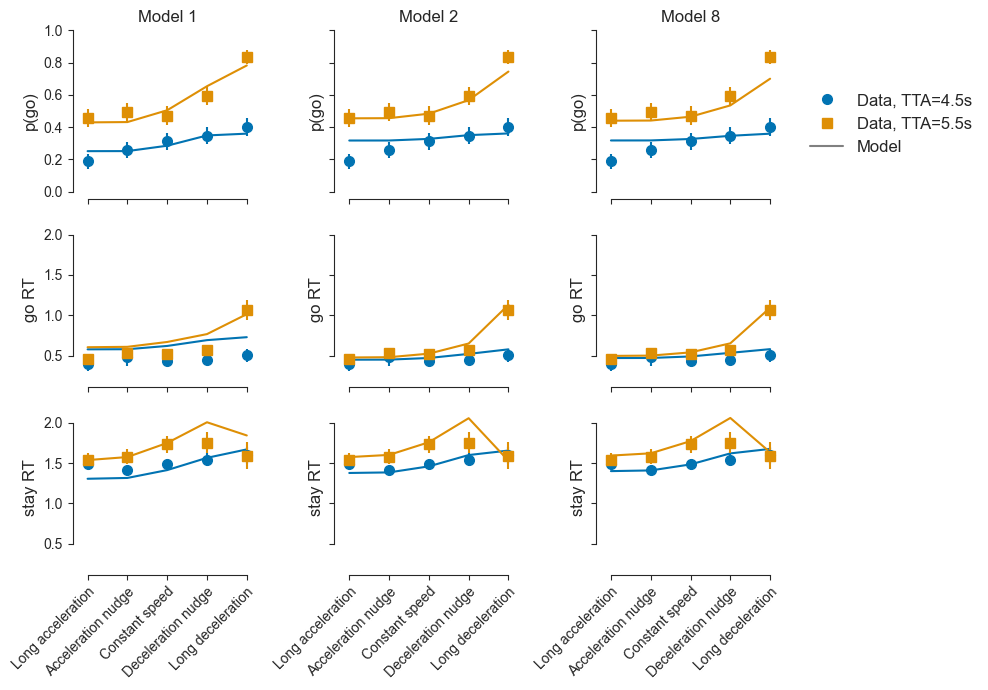

In [107]:
fig, axes = plt.subplots(3, 3, figsize=(8, 7), sharex=True, sharey="row")

for model_no, ax_col in zip([1, 2, 8], axes.T):
    path = os.path.join("modeling/fit_results_bic" , "model_%i" % (model_no))
    model_measures = pd.read_csv(os.path.join(path, "subj_all_sim_measures.csv"))
    model_measures["a_values"] = model_measures.a_values.apply(ast.literal_eval).apply(tuple)
    model_measures["condition"] = pd.Categorical(model_measures["a_values"].map(condition_map), categories=condition_map.values(), ordered=True)
    
    plot_var_by_condition(exp_measures_no_missing_RT, model_measures, var="is_go_decision", include_model=True, include_legend=True if model_no>2 else False, legend_position=(1, 0.75), subfigure_label="", fig=fig, ax=ax_col[0])
    ax_col[0].set_title("Model %i" % model_no)
    plot_var_by_condition(exp_measures_no_missing_RT, model_measures, var="RT_go", include_model=True, include_legend=False, subfigure_label="", fig=fig, ax=ax_col[1])
    plot_var_by_condition(exp_measures_no_missing_RT, model_measures, var="RT_stay", include_model=True, include_legend=False, subfigure_label="", fig=fig, ax=ax_col[2])
    
for ax in axes[2]:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
fig.set_tight_layout(True)

plt.savefig("figures/models.pdf", bbox_inches="tight")

# Figure 5: Full RT distributions (experiment & Model 2)

In [30]:
loss = "bic"
model_no = 2
path = os.path.join("modeling/fit_results_%s" % (loss) , "model_%i" % (model_no))
model_rt_pdf = pd.read_csv(os.path.join(path, "subj_all_sim_rt_pdf.csv"))
model_rt_pdf["a_values"] = model_rt_pdf.a_values.apply(ast.literal_eval).apply(tuple)
model_rt_pdf["condition"] = pd.Categorical(model_rt_pdf["a_values"].map(condition_map), categories=condition_map.values(), ordered=True)

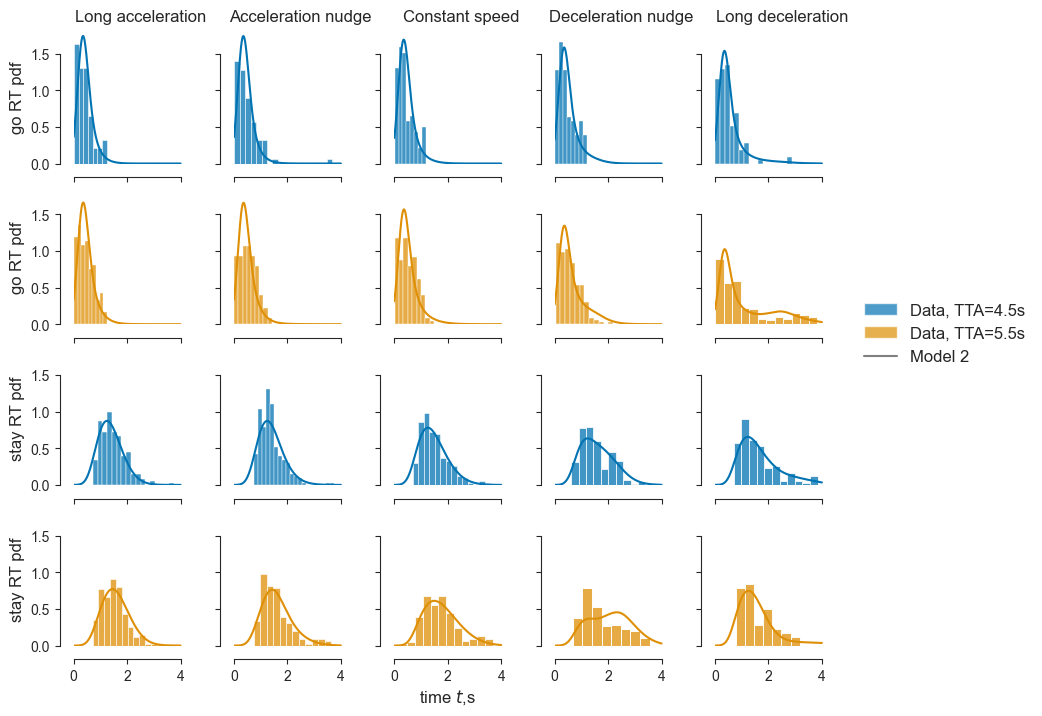

In [34]:
tta_conditions = [4.5, 5.5]
colors = ["C0", "C1"]

fig, axes = plt.subplots(4, 5, figsize=(10, 8), sharex=True, sharey=True)

for decision, ax_rows in zip(["go", "stay"], [axes[:2], axes[2:]]):
    for ax_row, tta_0, color in zip(ax_rows, tta_conditions, colors):
        for ax, condition in zip(ax_row, conditions):
            sns.lineplot(data=model_rt_pdf[(model_rt_pdf.condition==condition) & (model_rt_pdf.tta_0==tta_0)], x="t", y="rt_%s_distr" % decision, color=color, ax=ax)
            # data = model_rt_pdf[(model_rt_pdf.condition==condition) & (model_rt_pdf.tta_0==tta_0)]
            # ax.plot(data["t"], data["rt_%s_distr" % decision], color=color)
            data = exp_measures_no_missing_RT[(exp_measures_no_missing_RT.decision==decision.title()) 
                                                         & (exp_measures_no_missing_RT.condition==condition) 
                                                         & (exp_measures_no_missing_RT.tta_0==tta_0)]
            sns.histplot(data=data, 
                         x="RT", stat="density", color=color, ax=ax)
            ax.set_xlabel("")
            ax.set_ylabel("%s RT pdf" % decision, fontsize=12)
            ax.set_xlim((0, 5))
            # ax.set_title(str(len(data)))
            sns.despine(offset=10, trim=True)
            if (tta_0 == 4.5) & (decision=="go"):
                ax.set_title(condition)     

fig.text(s="time $t$,s", x=0.47, y=0.04, fontsize=12)
legend_elements = ([Patch(facecolor=color, alpha=0.7, label="Data, TTA=%.1fs" % (tta_0)) for tta_0, color in zip(tta_conditions, colors)]
                       + ([Line2D([0], [0], color="grey", label="Model 2")]))
    
fig.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(0.9, 0.5), fontsize=12, frameon=False)
plt.savefig("figures/rt_pdf.pdf", bbox_inches="tight")

# Figure 6: Model predictions

In [13]:
model_no = 2
path = os.path.join("modeling/fit_results_bic" , "model_%i" % (model_no))
model_measures = pd.read_csv(os.path.join(path, "prediction_subj_all_sim_measures.csv"))
model_measures["a_values"] = model_measures.a_values.apply(ast.literal_eval).apply(tuple)
model_measures["a_magnitude"] = model_measures.a_values.apply(lambda x: x[2])

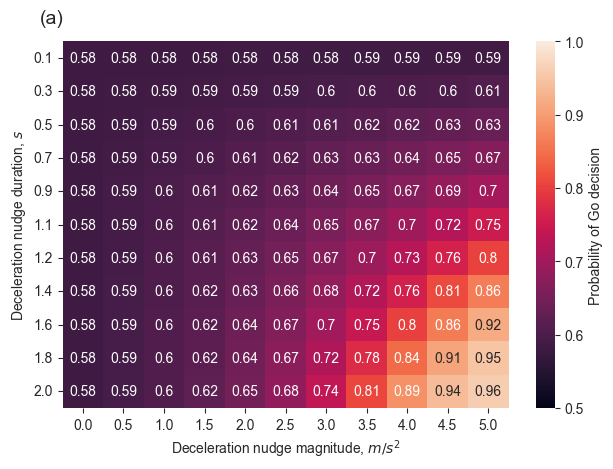

In [21]:
p_go = model_measures.pivot(index="a_duration", columns="a_magnitude", values="is_go_decision")
ax = sns.heatmap(p_go, vmin=0.5, vmax=1, annot=True, cbar_kws={"label": "Probability of Go decision"})
ax.set_xlabel("Deceleration nudge magnitude, $m/s^2$")
ax.set_ylabel("Deceleration nudge duration, $s$")
ax.set_yticklabels(['{:,.1f}'.format(x) for x in p_go.index.get_level_values(0)]);
plt.text(-0.55, -0.55, "(a)", fontsize=14)
plt.tight_layout()
plt.savefig("figures/predictions_p_go.pdf", bbox_inches="tight")

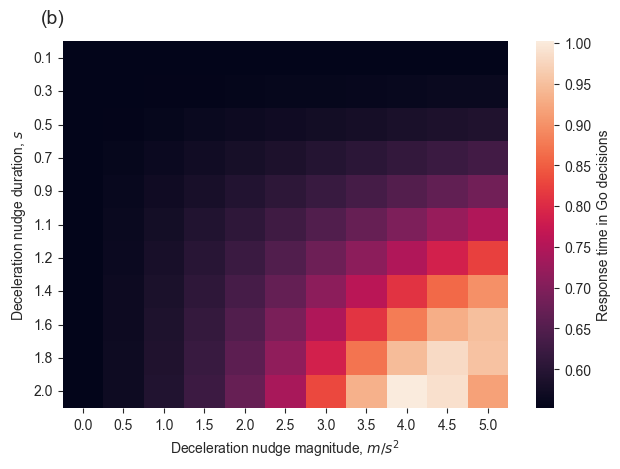

In [19]:
rt_go = model_measures.pivot(index="a_duration", columns="a_magnitude", values="RT_go")
ax = sns.heatmap(rt_go, cbar_kws={"label": "Response time in Go decisions"})
ax.set_xlabel("Deceleration nudge magnitude, $m/s^2$")
ax.set_ylabel("Deceleration nudge duration, $s$")
ax.set_yticklabels(['{:,.1f}'.format(x) for x in p_go.index.get_level_values(0)]);
plt.text(-0.55, -0.55, "(b)", fontsize=14)
plt.tight_layout()
plt.savefig("figures/predictions_RT_go.pdf", bbox_inches="tight")

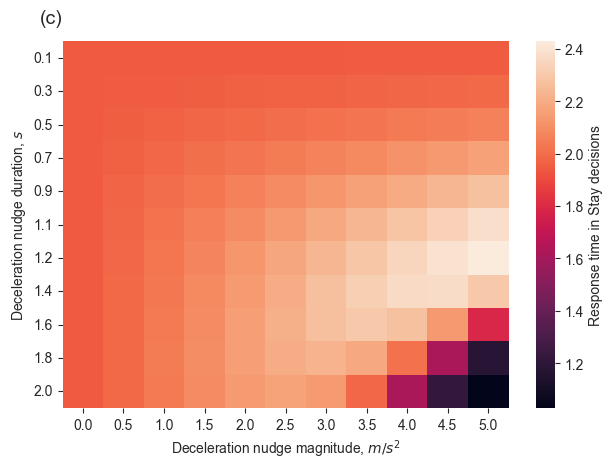

In [20]:
rt_stay = model_measures.pivot(index="a_duration", columns="a_magnitude", values="RT_stay")
ax = sns.heatmap(rt_stay, cbar_kws={"label": "Response time in Stay decisions"})
ax.set_xlabel("Deceleration nudge magnitude, $m/s^2$")
ax.set_ylabel("Deceleration nudge duration, $s$")
ax.set_yticklabels(['{:,.1f}'.format(x) for x in p_go.index.get_level_values(0)]);
plt.text(-0.55, -0.55, "(c)", fontsize=14)
plt.tight_layout()
plt.savefig("figures/predictions_RT_stay.pdf", bbox_inches="tight")

# Supplementary material: Negative ratings

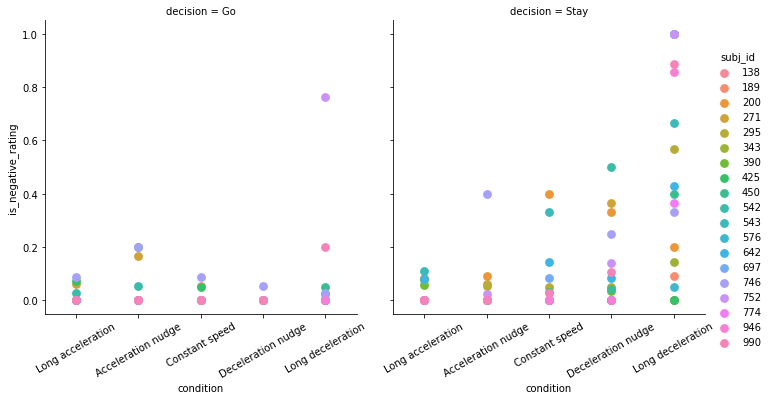

In [43]:
g = sns.catplot(exp_measures, x="condition", y="is_negative_rating", col="decision", hue="subj_id", kind="point", errorbar=None, join=False)
g.set_xticklabels(rotation=30)

# Supplementary material: RT distributions

<Axes: >

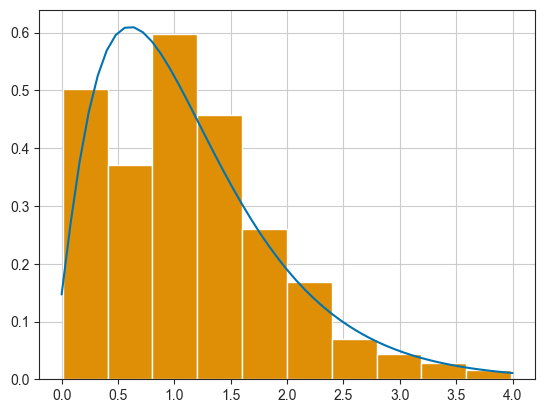

In [45]:
fit_alpha, fit_loc, fit_beta=scipy.stats.gamma.fit(exp_measures[exp_measures.RT<4].RT)
x = np.linspace(0, 4, 51)
y = scipy.stats.gamma.pdf(x-fit_loc, a=fit_alpha, scale=fit_beta)
plt.plot(x, y)
exp_measures[exp_measures.RT<4].RT.hist(density=True)

C:\Users\azgonnikov\AppData\Local\Temp\ipykernel_26068\409041352.py:1: UserWarning: 
The palette list has fewer values (6) than needed (19) and will cycle, which may produce an uninterpretable plot.
  sns.displot(data=exp_measures, x="RT", hue="subj_id", col="decision", kind="kde", clip=(0, 6), palette=sns.color_palette("husl"))


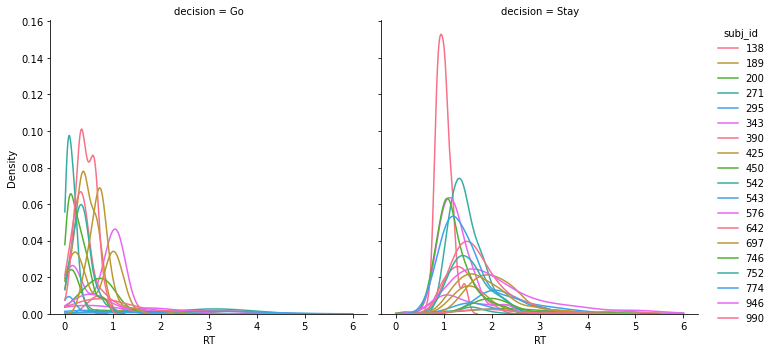

In [26]:
sns.displot(data=exp_measures, x="RT", hue="subj_id", col="decision", kind="kde", clip=(0, 6), palette=sns.color_palette("husl"))

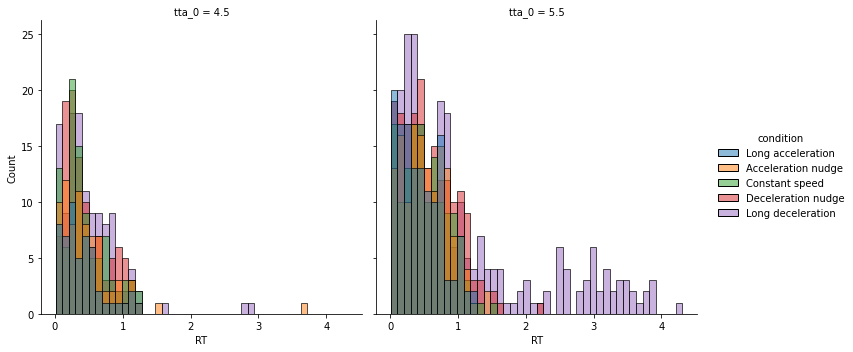

In [12]:
sns.displot(data=exp_measures[exp_measures.decision=="Go"], x="RT", hue="condition", col="tta_0", kind="hist")

In [33]:
exp_measures[(exp_measures.decision=="Go") & (exp_measures.condition=="Long deceleration") & (exp_measures.RT>1.5)].groupby("subj_id").count().RT

subj_id
189     2
295     9
343    10
390    12
450     4
576    10
642     2
752    15
774     2
Name: RT, dtype: int64

C:\Users\azgonnikov\AppData\Local\Temp\ipykernel_26068\4022709252.py:1: UserWarning: 
The palette list has fewer values (6) than needed (19) and will cycle, which may produce an uninterpretable plot.
  sns.displot(data=exp_measures[(exp_measures.decision=="Go")
C:\Users\azgonnikov\AppData\Local\Temp\ipykernel_26068\4022709252.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(data=exp_measures[(exp_measures.decision=="Go")


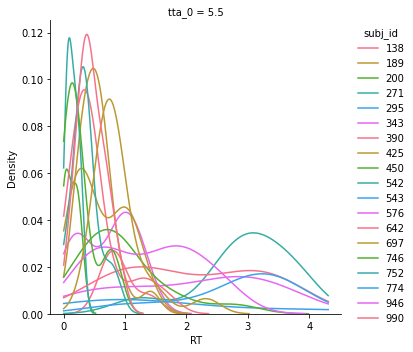

In [27]:
sns.displot(data=exp_measures[(exp_measures.decision=="Go")
                              & (exp_measures.tta_0==5.5)
                              & (exp_measures.condition=="Long deceleration")],
            x="RT", hue="subj_id", col="tta_0", kind="kde",
            clip=(0.0, exp_measures[exp_measures.decision=="Go"].RT.max()),
            palette=sns.color_palette("husl"))

# Supplementary material: Compare all candidate models

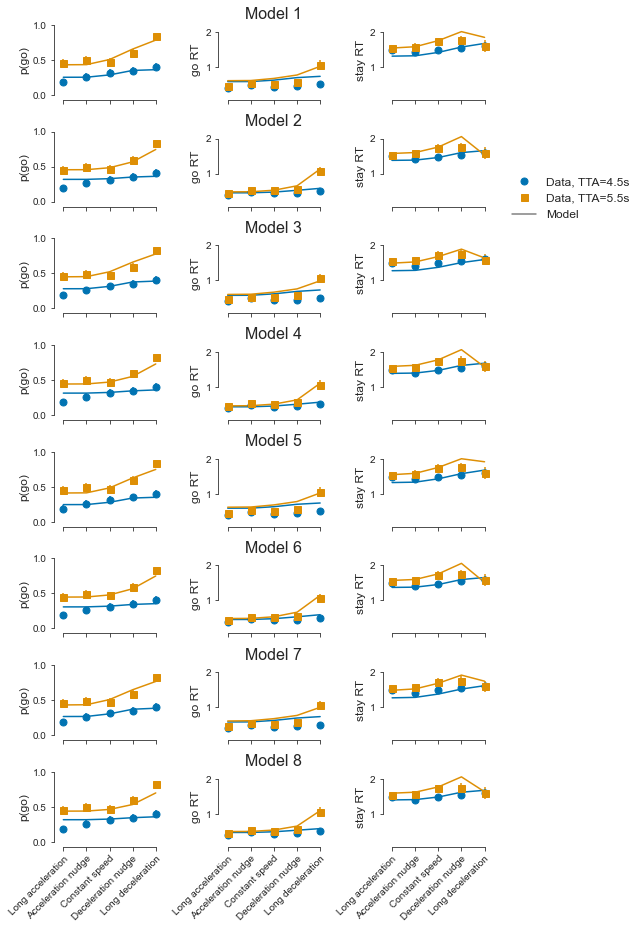

In [15]:
fig, axes = plt.subplots(8, 3, figsize=(7, 13), sharey="col", sharex="col")

for model_no, ax_row in zip(range(1,9), axes):
    path = os.path.join("modeling/fit_results_bic" , "model_%i" % (model_no))
    model_measures = pd.read_csv(os.path.join(path, "subj_all_sim_measures.csv"))
    model_measures["a_values"] = model_measures.a_values.apply(ast.literal_eval).apply(tuple)
    model_measures["condition"] = pd.Categorical(model_measures["a_values"].map(condition_map), categories=condition_map.values(), ordered=True)

    plot_var_by_condition(exp_measures_no_missing_RT, model_measures, var="is_go_decision", include_model=True, include_legend=True if model_no==1 else False, legend_position=(1, 0.75), subfigure_label="", fig=fig, ax=ax_row[0])
    plot_var_by_condition(exp_measures_no_missing_RT, model_measures, var="RT_go", include_model=True, include_legend=False, subfigure_label="", fig=fig, ax=ax_row[1])
    ax_row[1].set_title("Model %i" % model_no, fontsize=16)
    plot_var_by_condition(exp_measures_no_missing_RT, model_measures, var="RT_stay", include_model=True, include_legend=False, subfigure_label="", fig=fig, ax=ax_row[2])

for ax in axes[7]:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

fig.set_tight_layout(True)

plt.savefig("figures/si_models.pdf", bbox_inches="tight")

### Print params

In [53]:
def get_params(model_no):
    path = os.path.join("modeling/fit_results_bic", "model_%i" % (model_no))
    params = pd.read_csv(os.path.join(path, "subj_all_parameters_fitted.csv"))
    params["model_no"] = model_no
    return(params)

all_params = pd.concat([get_params(model_no) for model_no in range(1, 9)]).reindex()
all_params = all_params.drop(["subj_id"], axis=1)
all_params = all_params.set_index("model_no")
all_params.index.name = "Model"

var_names = {"loss": "BIC",
             "alpha": "$\\alpha$",
             "beta_d": "$\\beta_d$",
             "theta": "$\\theta_{\\textrm{crit}}$",
             "beta_a": "$\\beta_a$",
             "x0": "$x_0$",
             "B": "$B$",             
             "b_0": "$b_0$",
             "k": "$k$",
             "tta_crit": "$\\tau$",
             "ndt_location": "$\mu_{\\textrm{ND}}$",
             "ndt_scale": "$\sigma_{\\textrm{ND}}$"}

var_formats = {"loss": "{:0.0f}",
             "alpha": "{:.2f}",
             "beta_d": "{:0.3f}",
             "theta": "{:0.1f}",
             "B": "{:0.1f}",
             "ndt_location": "{:0.2f}",
             "ndt_scale": "{:0.2f}",
             "x0": "{:0.2f}",
             "b_0": "{:0.2f}",
             "k": "{:0.4f}",
             "tta_crit": "{:0.2f}",
             "beta_a": "{:0.4f}"}

for col, f in var_formats.items():
    all_params[col] = all_params[col].map(lambda x: f.format(x))

all_params[all_params=="nan"] = "-"

styler = all_params.T.rename(index=var_names).style

with open('figures/tab_si_params.tex', 'w') as tf:
     tf.write(styler.to_latex(
         column_format="rrrrrrrrr", position="h", position_float="centering",
         hrules=True, label="tab:si_params", caption="Fitted parameters for eight candidate models"
     )
)

### Compare BIC values

In [115]:
loss = "bic"

print("model", "BIC", "k")
for model_no in range(1, 9):
    path = os.path.join("modeling/fit_results_%s" % (loss) , "model_%i" % (model_no))
    params = pd.read_csv(os.path.join(path, "subj_all_parameters_fitted.csv"))
    print(model_no, params.loss.values[0], params.size-2)

model BIC k
1 5049.793516874082 6
2 4609.55439075354 7
3 5072.372683461188 8
4 4622.0068097112935 9
5 5062.521094344943 7
6 4619.776214502094 8
7 5089.64450618534 9
8 4638.205871411643 10


### Compare p(Go)

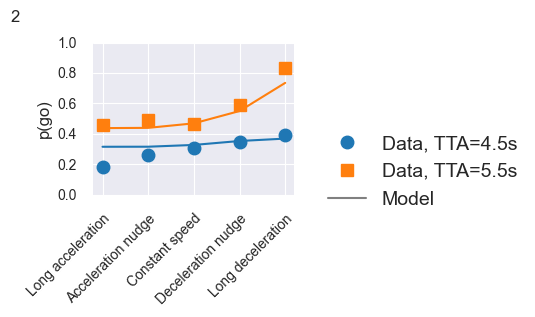

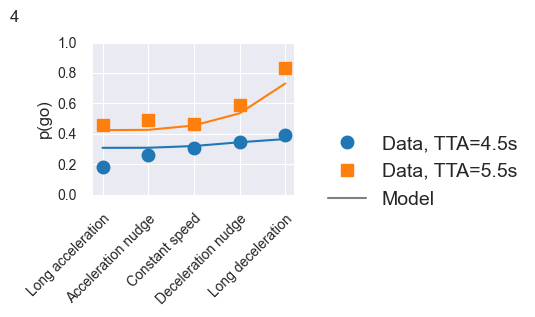

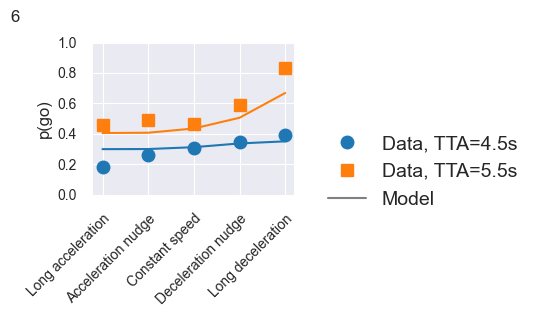

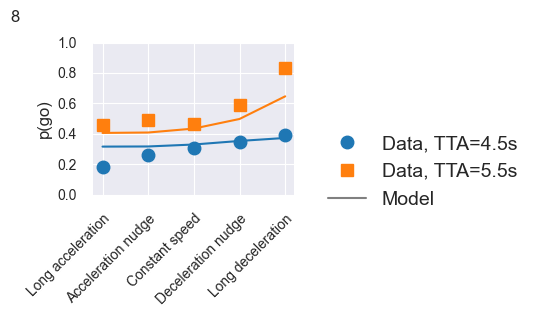

In [80]:
plot_models_vs_data("is_go_decision", [2, 4, 6, 8])

### Compare RT

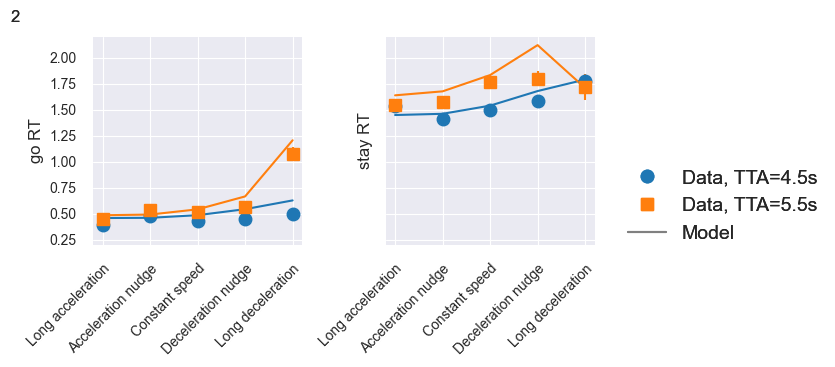

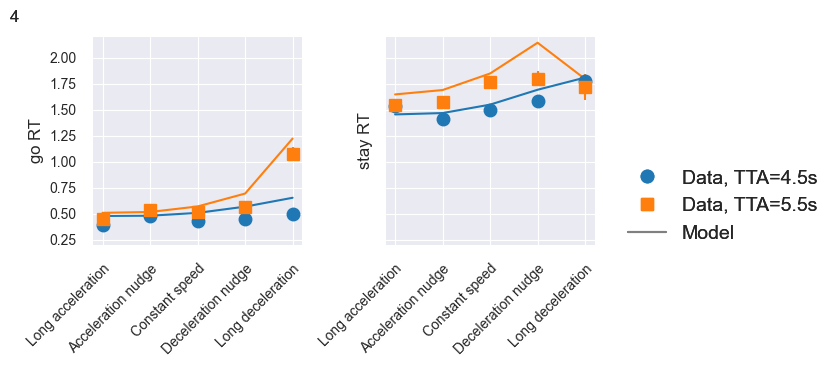

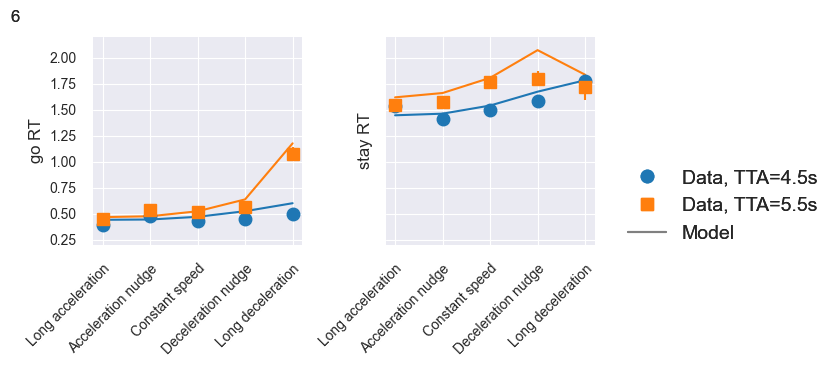

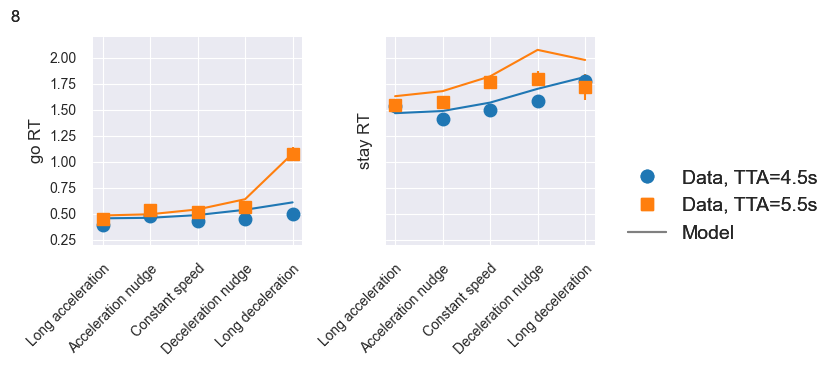

In [81]:
plot_models_vs_data("RT", [2, 4, 6, 8])

# Supplementary material: Compare fitting results for different loss functions

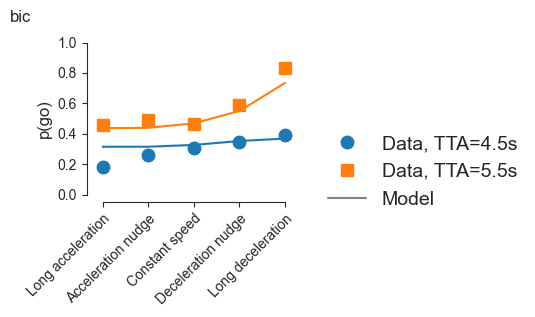

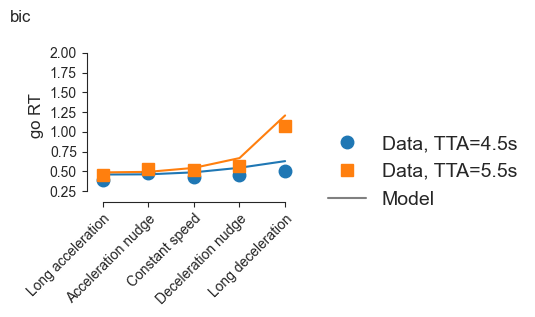

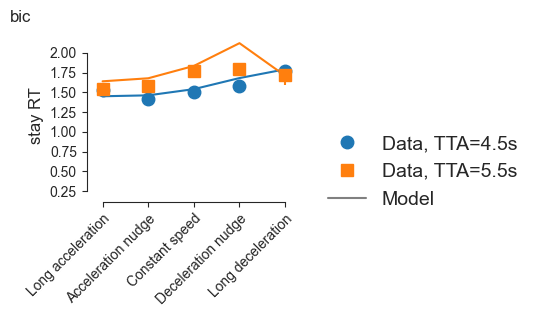

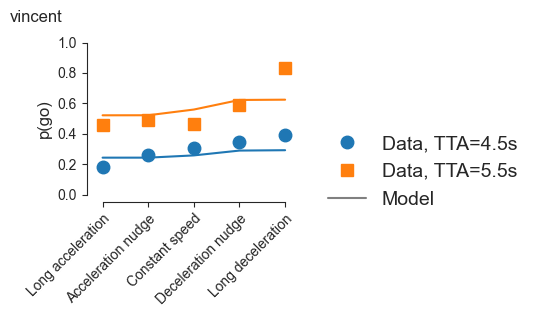

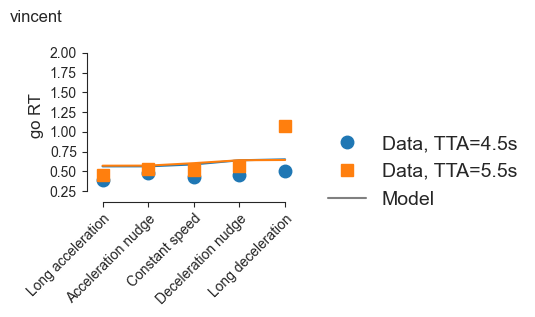

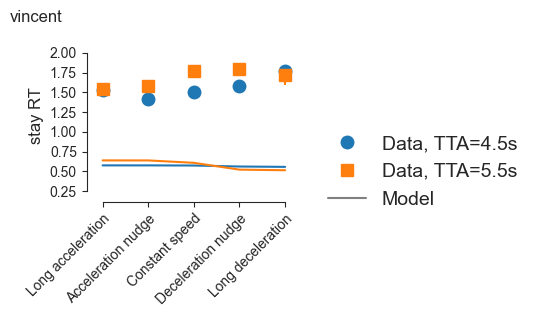

In [10]:
model_no = 2

for loss in ["bic", "vincent"]:
    path = os.path.join("modeling/fit_results_%s" % (loss) , "model_%i" % (model_no))
    model_measures = pd.read_csv(os.path.join(path, "subj_all_sim_measures.csv"))
    model_measures["a_values"] = model_measures.a_values.apply(ast.literal_eval).apply(tuple)
    model_measures["condition"] = pd.Categorical(model_measures["a_values"].map(condition_map), categories=condition_map.values(), ordered=True)
    plot_var_by_condition(exp_measures[~np.isnan(exp_measures.RT)], model_measures, var="is_go_decision", model_label=str(model_no), include_model=True, include_legend=True, subfigure_label=loss)
    plot_var_by_condition(exp_measures[~np.isnan(exp_measures.RT)], model_measures, var="RT_go", model_label=str(model_no), include_model=True, include_legend=True, subfigure_label=loss)
    plot_var_by_condition(exp_measures[~np.isnan(exp_measures.RT)], model_measures, var="RT_stay", model_label=str(model_no), include_model=True, include_legend=True, subfigure_label=loss)

# Misc: summary statistics

Average minimum distance to the truck

In [4]:
print(exp_measures.gap_to_truck.mean(), exp_measures.gap_to_truck.std())

AttributeError: 'DataFrame' object has no attribute 'gap_to_truck'

# Misc: Checking TTA and boundaries

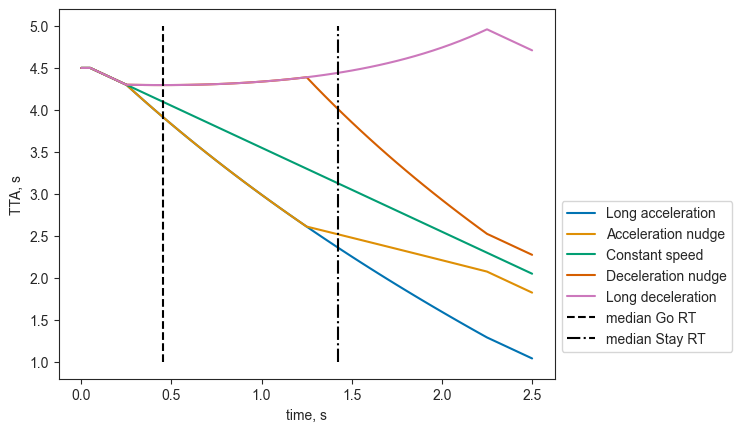

In [35]:
T_dur = 2.5
t_values = np.linspace(0, T_dur, 51)
d_0 = 80
tta_0 = 4.5
# plt.plot(t, tta_0-t, label="Constant speed")
# ax = plt.gca()

a_duration = 1
breakpoints = np.array([0., 0.25, (0.25+a_duration), min(0.25 + a_duration*2, T_dur)] + [T_dur])
v_0 = d_0 / tta_0

for a_values, label in zip([[0, 4, 4, 0], [0, 4, -4, 0], [0, 0, 0, 0], [0, -4, 4, 0], [0, -4, -4, 0]],
                           ["Long acceleration", "Acceleration nudge", "Constant speed", "Deceleration nudge", "Long deceleration"]):
    a_values = np.concatenate([a_values, [0.]])
    v_values = np.concatenate([[v_0], v_0 + np.cumsum(np.diff(breakpoints) * a_values[:-1])])
    f_a = interpolate.interp1d(breakpoints, a_values, kind=0)
    f_v = interpolate.interp1d(breakpoints, v_values, kind=1)

    f_d = lambda t: d_0 - np.trapz(f_v(t_values[t_values<t]), x=t_values[t_values<t])
    # d_values = np.concatenate([[d_0], d_0 - np.cumsum(np.diff(breakpoints) * (v_values[1:] + v_values[:-1]) / 2)])
    d_values = [f_d(t) for t in t_values]

    # plt.plot(t_values, d_values, label=label)
    # tta_values = (d_0 - f_d(t_values)) / f_v(t_values)
    tta_values = d_values / f_v(t_values)
    # f_tta = interpolate.interp1d(breakpoints, tta_values, kind=1)
    tta_dot_values = utils.get_derivative(t_values, tta_values)
    # plt.plot(t_values, f_v(t_values), label=label)
    plt.plot(t_values, tta_values, label=label)
    # plt.plot(t_values, tta_dot_values+1, label=label)
    # plt.plot(t_values, f_a(t_values), label=label)
    

ax = plt.gca()
ax.vlines([exp_measures[exp_measures.is_go_decision].RT.median()], ymin=1, ymax=5, ls="--", color="k", label="median Go RT")
ax.vlines([exp_measures[~exp_measures.is_go_decision].RT.median()], ymin=1, ymax=5, ls="-.", color="k", label="median Stay RT")
ax.set_xlabel("time, s")
ax.set_ylabel("TTA, s")

plt.legend(bbox_to_anchor=(1, 0.5))

In [76]:
path = os.path.join("modeling/fit_results_%s" % (loss) , "model_%i" % (model_no))
parameters = pd.read_csv(os.path.join(path, "subj_all_parameters_fitted.csv"))
# parameters["k"] = 0.2

In [77]:
parameters

,subj_id,loss,alpha,beta_d,beta_a,theta,b_0,k,tta_crit,x0,ndt_location,ndt_scale
0,all,4862.10421,0.351732,0.0014,0.025167,7.369282,2.75683,0.026918,4.918254,0.653195,0.14093,0.164372


(0.0, 1.389207601686892)

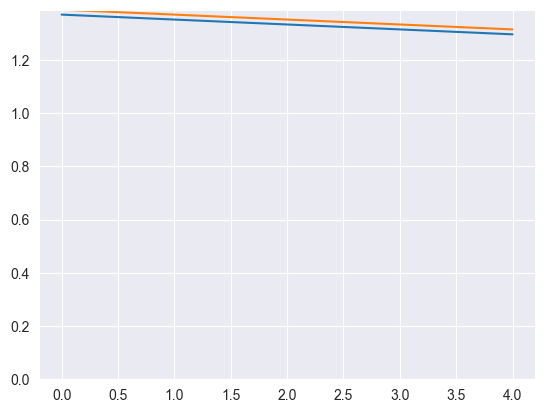

In [78]:
T_dur = 4
t = np.linspace(0, T_dur, 51)
b_45 = parameters["b_0"].values / (1 + np.exp(-parameters["k"].values * ((4.5-t) - parameters["tta_crit"].values)))
plt.plot(t, b_45)
b_55 = parameters["b_0"].values / (1 + np.exp(-parameters["k"].values * ((5.5-t) - parameters["tta_crit"].values)))
plt.plot(t, b_55)
ax = plt.gca()
ax.set_ylim((0, b_55[0]))

# Misc: Vincentized vs pooled data

In [11]:
exp_RTs = exp_measures[(exp_measures.RT < 4)]
exp_RTs[exp_RTs.is_go_decision].groupby("subj_id").count()

,session,route,intersection_no,idx_bot_visible,idx_response,idx_yield,idx_min_distance,min_distance,RT_gas,RT_yield,is_negative_rating,is_go_decision,tta_0,d_0,a_values,a_duration,decision,RT,condition
subj_id,,,,,,,,,,,,,,,,,,,
138,163,163,163,163,163,163,163,163,163,163,163,163,163,163,163,163,163,163,163
189,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105
200,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98,98
271,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90
295,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
343,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44,44
390,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47
425,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105,105
450,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58


## Quantile functions

In [16]:
rt_quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
# rt_quantiles = [0.5]
# First, get RT quantiles at these levels from the pooled data
go_RT_quantiles_pooled = np.quantile(a=exp_RTs[exp_RTs.is_go_decision].RT, q=rt_quantiles)
# Second, get them per participant and average over all p's
go_RT_quantiles_vincentized = (exp_RTs[exp_RTs.is_go_decision].groupby("subj_id").apply(lambda group: np.quantile(a=group.RT, q=rt_quantiles))).mean()


In [17]:
go_RT_quantiles_pooled

array([0.0966 , 0.28175, 0.4535 , 0.71755, 1.1126 ])

In [18]:
go_RT_quantiles_vincentized

array([0.27286263, 0.48691158, 0.77130789, 0.98170474, 1.45543684])

## Mean values per condition

Vincentized

In [36]:
between_subj_mean = exp_RTs[exp_RTs.is_go_decision].groupby(["subj_id", "tta_0", "condition"]).RT.mean()

In [39]:
between_subj_mean.groupby(["tta_0", "condition"]).mean()

tta_0  condition         
4.5    Long acceleration     0.401087
       Acceleration nudge    0.668401
       Constant speed        0.432536
       Deceleration nudge    0.422876
       Long deceleration     0.524226
5.5    Long acceleration     0.449137
       Acceleration nudge    0.562749
       Constant speed        0.546362
       Deceleration nudge    0.573357
       Long deceleration     1.017075
Name: RT, dtype: float64

Pooled

In [40]:
exp_RTs[exp_RTs.is_go_decision].groupby(["tta_0", "condition"]).RT.mean()

tta_0  condition         
4.5    Long acceleration     0.394160
       Acceleration nudge    0.483165
       Constant speed        0.433556
       Deceleration nudge    0.448616
       Long deceleration     0.501627
5.5    Long acceleration     0.453072
       Acceleration nudge    0.534826
       Constant speed        0.516158
       Deceleration nudge    0.569424
       Long deceleration     1.075781
Name: RT, dtype: float64

## Distributions

In [13]:
def plot_condition_vincentized_dist(ax, condition, condition_data, kind="cdf"):
    # colors = dict(zip([90,120,150], [plt.cm.viridis(r) for r in np.linspace(0.1,0.7,3)]))
    # markers={90: "o", 120: "s", 150: "^"}
    #     q = [0.1, 0.3, 0.5, 0.7, 0.9]
    q = np.linspace(0.01, 0.99, 15)
    condition_quantiles = condition_data.groupby("subj_id").apply(lambda d: np.quantile(a=d.RT, q=q)).mean()

    rt_range = np.linspace(condition_quantiles.min(), condition_quantiles.max(), len(q))
    step = rt_range[1] - rt_range[0]
    rt_grid = np.concatenate([rt_range[:3] - 3 * step, rt_range, rt_range[-3:] + step * 3])

    vincentized_cdf = np.interp(rt_grid, condition_quantiles, q, left=0, right=1)

    if kind=="cdf":
        dist = vincentized_cdf
    elif kind=="pdf":
        dist = utils.get_derivative(rt_grid, vincentized_cdf)

    ax.plot(rt_grid, dist, label="vincentized", color="grey", ls="", ms=9, marker="o")
    ax.set_ylim([-0.05, 1.1])
    ax.set_yticks([0.0, 0.5, 1.0])

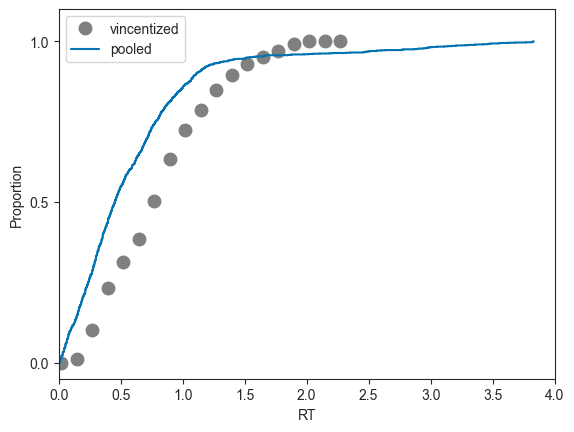

In [14]:
fig, ax = plt.subplots()
plot_condition_vincentized_dist(ax, condition=None, condition_data=exp_RTs[exp_RTs.is_go_decision])
sns.ecdfplot(exp_RTs[exp_RTs.is_go_decision].RT, label="pooled")
ax.set_xlim((0,4))
plt.legend()

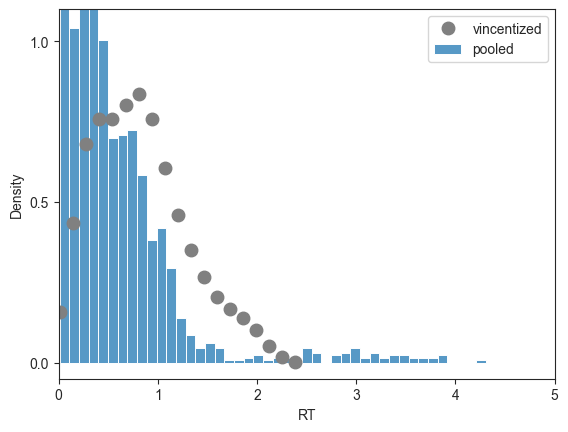

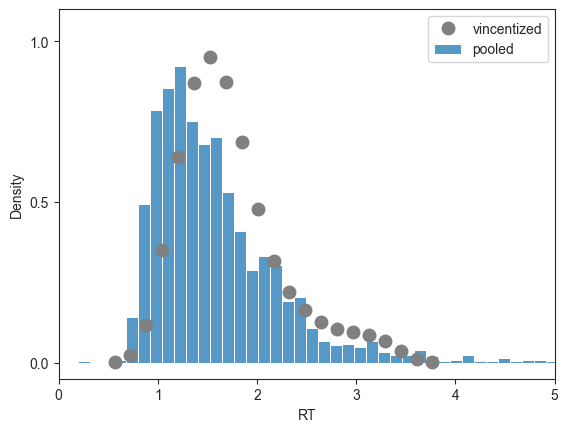

In [42]:
for decision in ["Go", "Stay"]:
    fig, ax = plt.subplots()
    plot_condition_vincentized_dist(ax, condition=None, condition_data=exp_RTs[exp_RTs.decision==decision], kind="pdf")
    sns.histplot(exp_RTs[exp_RTs.decision==decision].RT, stat="density", label="pooled")
    ax.set_xlim((0,5))
    plt.legend()